# Initialization

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [4]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

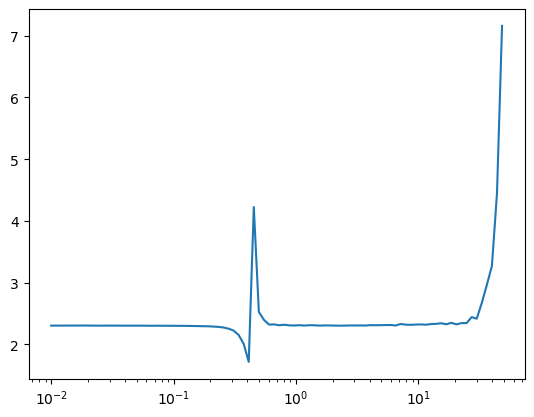

In [5]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [6]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.230,2.102,0,train
0.426,1.607,0,eval


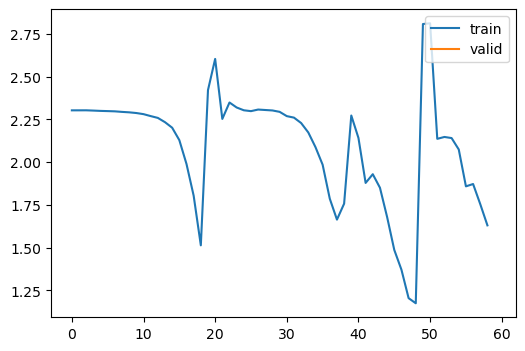

In [8]:
learn.fit(1)

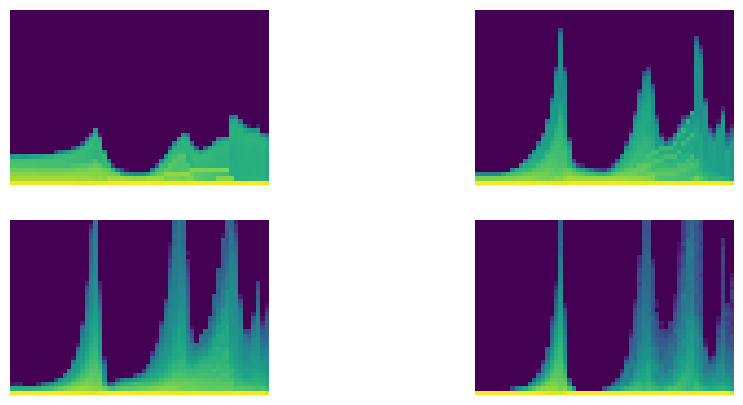

In [9]:
astats.color_dim()

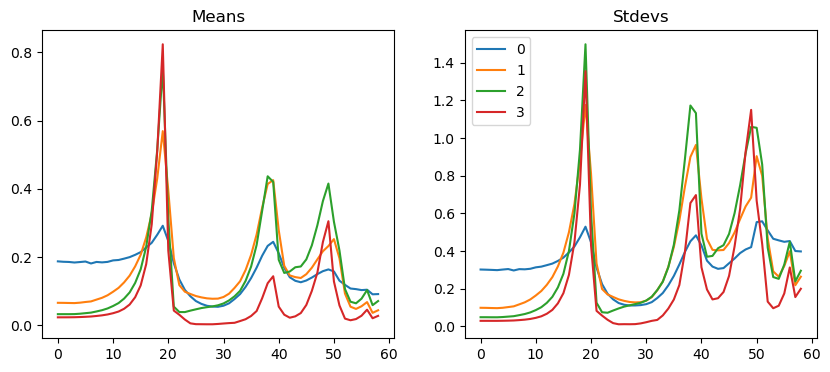

In [10]:
astats.plot_stats()

In [11]:
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [12]:
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [13]:
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

## Glorot/Xavier init

In [14]:
x = torch.randn(200,100)
for i in range(50): x = x @ torch.randn(100,100)
x[0:5,0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

The result is `nan`s everywhere. So maybe the scale of our matrix was too big, and we need to have smaller weights? But if we use too small weights, we will have the opposite problem—the scale of our activations will go from 1 to 0.1, and after 50 layers we'll be left with zeros everywhere:

In [15]:
x = torch.randn(200,100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.01)
x[0:5,0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

So we have to scale our weight matrices exactly right so that the standard deviation of our activations stays at 1. We can compute the exact value to use mathematically, as illustrated by Xavier Glorot and Yoshua Bengio in ["Understanding the Difficulty of Training Deep Feedforward Neural Networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). The right scale for a given layer is $1/\sqrt{n_{in}}$, where $n_{in}$ represents the number of inputs.

In [16]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.1)
x[0:5,0:5]

tensor([[ 1.33, -1.54,  0.54,  0.13,  3.51],
        [ 0.20,  0.95,  0.61, -0.02,  1.73],
        [-0.69,  1.72,  0.36, -0.64, -2.40],
        [ 0.03,  0.73,  0.40, -1.24, -0.64],
        [ 0.33, -0.33,  0.03, -0.32,  0.62]])

### Applying an init function

In [27]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [28]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.Linear)): init.kaiming_normal_(m.weight)

In [29]:
model.apply(init_weights);

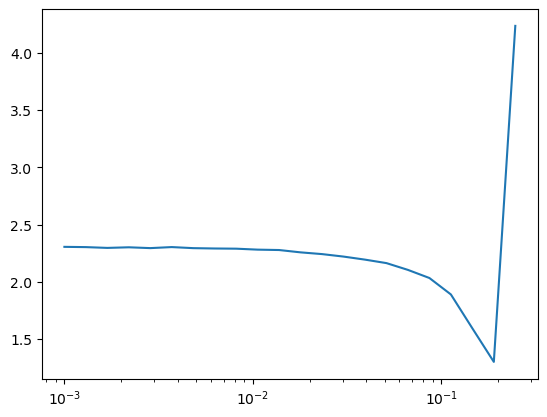

In [30]:
lrf_cbs = [DeviceCB(), ProgressCB(), LRFinderCB()]
learn = MomentumLearner(model, dls, F.cross_entropy, lr=1e-3, cbs=lrf_cbs)
learn.fit(1)

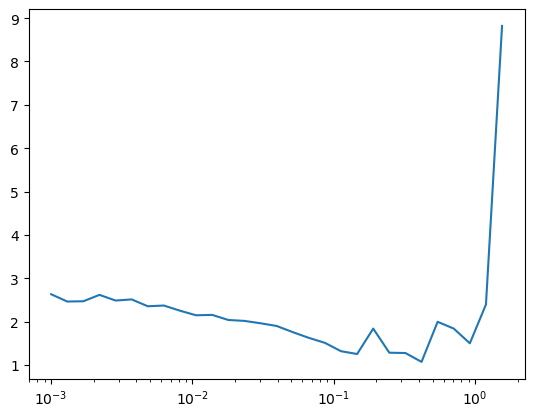

In [31]:
learn.fit(3)

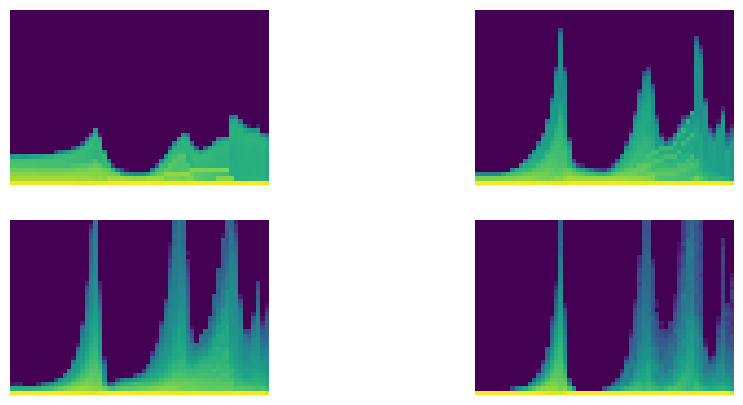

In [32]:
astats.color_dim()

## Input normalization

In [34]:
xmean,xstd = xb.mean(),xb.std()
xmean,xstd

(tensor(0.29), tensor(0.35))

In [40]:
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [41]:
def _norm(b): return (b[0] - xmean)/xstd,b[1]
norm = BatchTransformCB(_norm)

accuracy,loss,epoch,train
0.551,1.388,0,train
0.776,0.600,0,eval
0.808,0.520,1,train
0.824,0.484,1,eval
0.843,0.427,2,train
0.843,0.429,2,eval


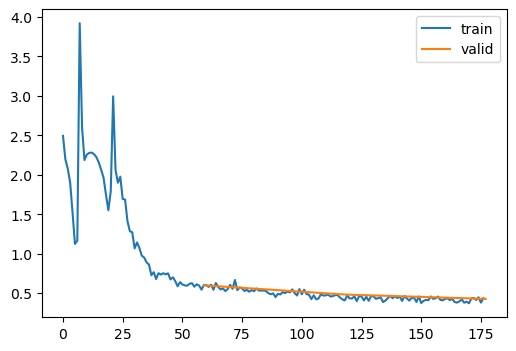

In [42]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)

In [43]:
@inplace 
def transformi(b): b[xl] = [(TF.to_tensor(o) - xmean)/xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers = 4)
xb, yb = next(iter(dls.train))

In [44]:
xb.mean(), xb.std()

(tensor(0.01), tensor(1.00))

## General ReLU

In [46]:
class GeneralRelu(nn.Module):
    def __init__(self, leak = None, sub = None, maxv = None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
    
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [47]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size = ks, padding = ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [48]:
def get_model(act = nn.ReLU, nfs = None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act = act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act = None), nn.Flatten()).to(def_device)

In [52]:
def init_weights(m, leaky = 0.):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)): init.kaiming_normal_(m.weight, a=leaky)

In [53]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [54]:
model = get_model(act_gr).apply(iw)

accuracy,loss,epoch,train
0.769,0.663,0,train
0.847,0.420,0,eval
0.867,0.362,1,train
0.865,0.368,1,eval
0.883,0.319,2,train
0.868,0.361,2,eval


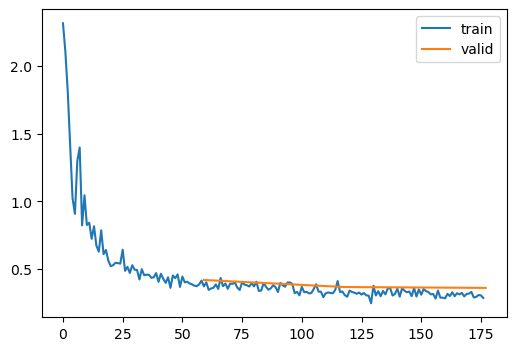

In [55]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

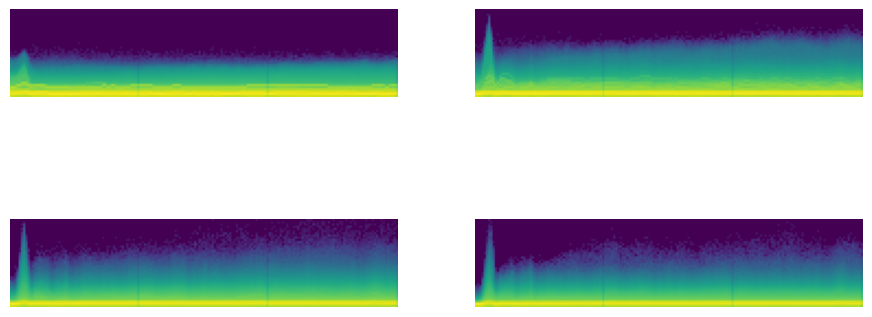

In [56]:
astats.color_dim()

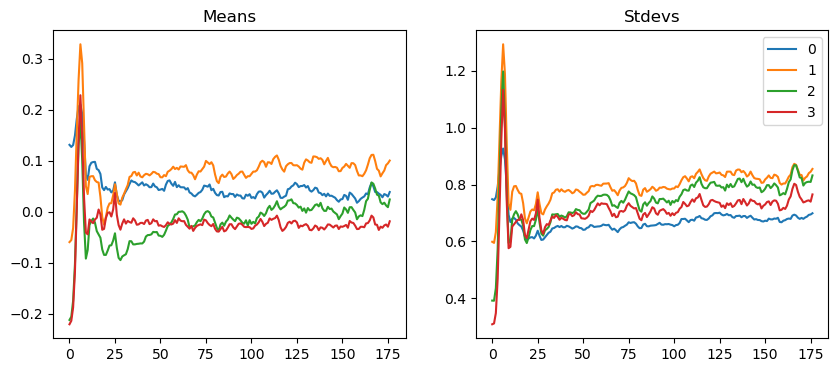

In [57]:
astats.plot_stats()

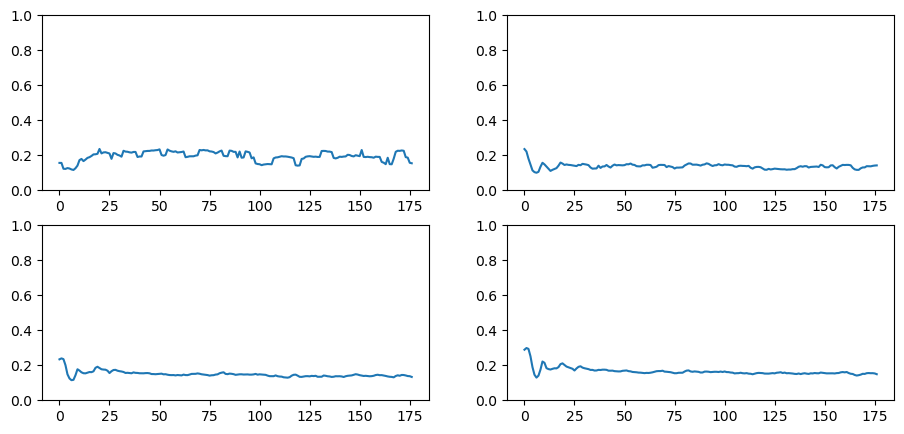

In [58]:
astats.dead_chart()

## LSUV

[All You Need is a Good Init](https://arxiv.org/pdf/1511.06422.pdf) introduces *Layer-wise Sequential Unit-Variance* (*LSUV*).

In [59]:
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()

def lsuv_init(m, m_in, xb):
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
    h.remove()

In [60]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [61]:
for ms in zip(relus,convs): print(ms)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [62]:
for ms in zip(relus,convs): lsuv_init(*ms, xb.to(def_device))

accuracy,loss,epoch,train
0.772,0.650,0,train
0.833,0.455,0,eval
0.863,0.377,1,train
0.851,0.397,1,eval
0.876,0.337,2,train
0.861,0.377,2,eval


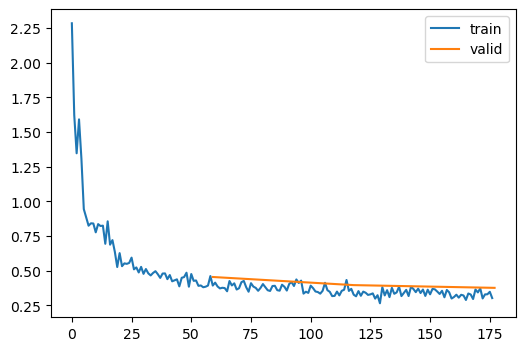

In [63]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

## Layer Normalization

In [64]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps = 1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
    
    def forward(self, x):
        m = x.mean((1,2,3), keepdim = True)
        v = x.var((1,2,3), keepdim = True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [66]:
def conv(ni, nf, ks = 3, stride = 2, act = nn.ReLU, norm = None, bias = True):
    layers = [nn.Conv2d(ni,nf, stride = stride, kernel_size= ks, padding= ks //2, bias = bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [68]:
def get_model(act = nn.ReLU, nfs = None, norm = None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act = act, norm = norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act = None, norm = None, bias = True if norm is None else False), nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.780,0.608,0,train
0.841,0.429,0,eval
0.866,0.364,1,train
0.857,0.389,1,eval
0.883,0.318,2,train
0.876,0.339,2,eval


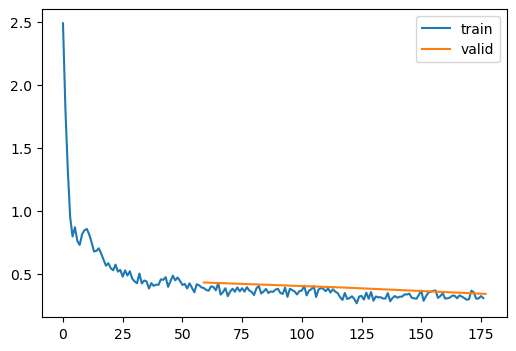

In [69]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs = cbs)
learn.fit(3)

## Batch Norm

In [70]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom = 0.1, eps = 1e-5):
        super().__init__()
        # NB: pytorch bn mom is the opposite of what you would expect
        self.mom,self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars', torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
    
    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim = True)
        v = x.var((0,2,3), keepdim = True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m,v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mults + self.adds

accuracy,loss,epoch,train
0.800,0.550,0,train
0.834,0.531,0,eval
0.873,0.344,1,train
0.862,0.380,1,eval
0.886,0.309,2,train
0.868,0.364,2,eval


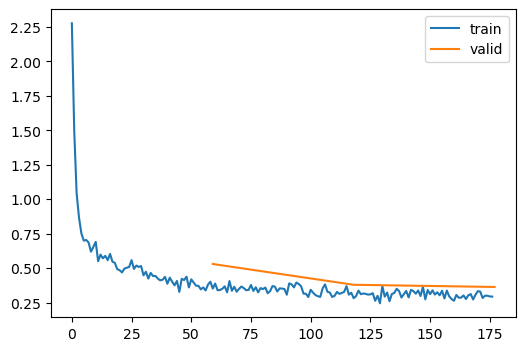

In [71]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr = 0.4, cbs = cbs)
learn.fit(3)

## Towards 90%

In [72]:
dls = DataLoaders.from_dd(tds, 256, num_workers = 4)

accuracy,loss,epoch,train
0.835,0.449,0,train
0.850,0.396,0,eval
0.882,0.316,1,train
0.874,0.352,1,eval
0.894,0.284,2,train
0.883,0.317,2,eval


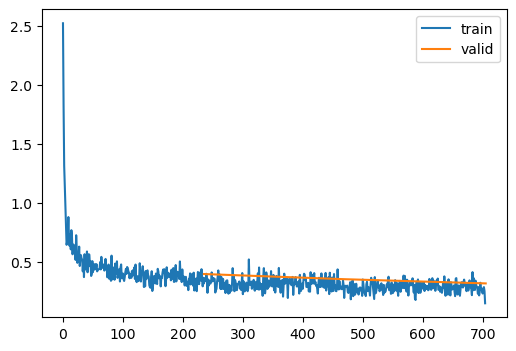

In [73]:
set_seed(42)
model = get_model(act_gr, norm = nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr = 0.2, cbs = cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.917,0.225,0,train
0.897,0.282,0,eval
0.921,0.213,1,train
0.896,0.287,1,eval


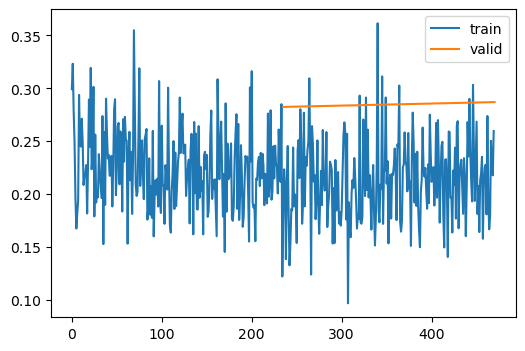

In [74]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr = 0.05, cbs = cbs)
learn.fit(2)